In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report,accuracy_score, mean_absolute_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from xgboost import XGBRegressor
from sklearn.ensemble import  RandomForestRegressor, BaggingRegressor

import math

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train_data = pd.read_csv("data/train.csv", index_col = 0)
test_data = pd.read_csv("data/test.csv", index_col = 0)
sample_submission = pd.read_csv('data/sample_submission.csv')

In [3]:
train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# Визуализация данных

Посмотрим на распределение по ценам

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

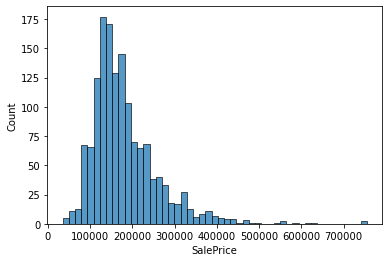

In [5]:
sns.histplot(train_data["SalePrice"])

Посмотрим на корреляцию признаков

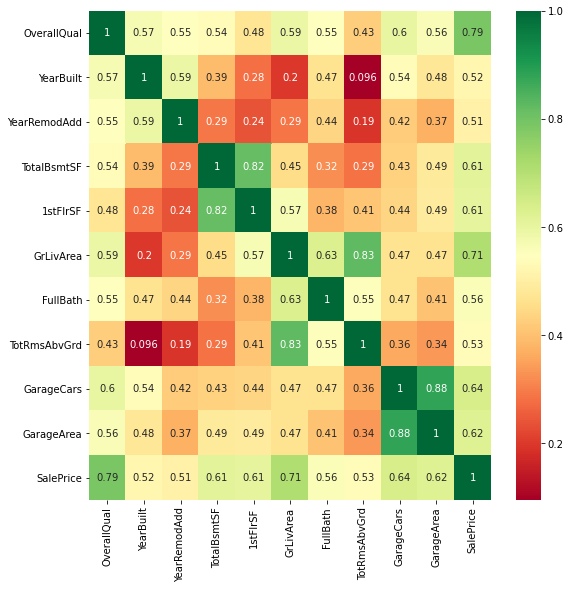

In [6]:
corrmat = train_data.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"]) > 0.5]
plt.figure(figsize = (9,9))
g = sns.heatmap(train_data[top_corr_features].corr(), annot=True, cmap="RdYlGn")

# Препроцессинг

## Train_data

In [7]:
train_data.isnull().sum()

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

In [8]:
total_null = train_data.isnull().sum().sort_values(ascending=False)
total_null.head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageCond        81
GarageFinish      81
GarageQual        81
GarageYrBlt       81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
RoofMatl           0
dtype: int64

In [9]:
train_data = train_data.drop(total_null[total_null.values > 100].index, 1)
train_data.isnull().sum().sort_values(ascending=False).head(20)

GarageType      81
GarageYrBlt     81
GarageFinish    81
GarageQual      81
GarageCond      81
BsmtFinType2    38
BsmtExposure    38
BsmtFinType1    37
BsmtCond        37
BsmtQual        37
MasVnrType       8
MasVnrArea       8
Electrical       1
YearRemodAdd     0
ExterQual        0
ExterCond        0
Exterior2nd      0
Exterior1st      0
Foundation       0
BsmtFinSF1       0
dtype: int64

In [10]:
numeric_names = train_data._get_numeric_data().columns.tolist()
numeric_names

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

In [11]:
for col in numeric_names:
    train_data[col].fillna(train_data[col].mean(), inplace=True)

In [12]:
categorial_names = set(train_data.columns) - set(numeric_names)
categorial_names

{'BldgType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtQual',
 'CentralAir',
 'Condition1',
 'Condition2',
 'Electrical',
 'ExterCond',
 'ExterQual',
 'Exterior1st',
 'Exterior2nd',
 'Foundation',
 'Functional',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'Heating',
 'HeatingQC',
 'HouseStyle',
 'KitchenQual',
 'LandContour',
 'LandSlope',
 'LotConfig',
 'LotShape',
 'MSZoning',
 'MasVnrType',
 'Neighborhood',
 'PavedDrive',
 'RoofMatl',
 'RoofStyle',
 'SaleCondition',
 'SaleType',
 'Street',
 'Utilities'}

In [13]:
for col in categorial_names:
    train_data[col].fillna(train_data[col].mode()[0], inplace=True)
train_data.isnull().sum().sort_values(ascending=False)

SalePrice       0
RoofStyle       0
Exterior1st     0
Exterior2nd     0
MasVnrType      0
               ..
KitchenAbvGr    0
KitchenQual     0
TotRmsAbvGrd    0
Functional      0
MSSubClass      0
Length: 74, dtype: int64

In [14]:
object_cols = [col for col in train_data.columns if train_data[col].dtype == "object"]
label_encoder=LabelEncoder()
for col in object_cols:
    train_data[col]=label_encoder.fit_transform(train_data[col])
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   int32  
 2   LotArea        1460 non-null   int64  
 3   Street         1460 non-null   int32  
 4   LotShape       1460 non-null   int32  
 5   LandContour    1460 non-null   int32  
 6   Utilities      1460 non-null   int32  
 7   LotConfig      1460 non-null   int32  
 8   LandSlope      1460 non-null   int32  
 9   Neighborhood   1460 non-null   int32  
 10  Condition1     1460 non-null   int32  
 11  Condition2     1460 non-null   int32  
 12  BldgType       1460 non-null   int32  
 13  HouseStyle     1460 non-null   int32  
 14  OverallQual    1460 non-null   int64  
 15  OverallCond    1460 non-null   int64  
 16  YearBuilt      1460 non-null   int64  
 17  YearRemodAdd   1460 non-null   int64  
 18  RoofStyl

## Test_data

In [15]:
test_data = test_data.drop(total_null[total_null.values > 100].index, 1)
total_null = test_data.isnull().sum().sort_values(ascending=False)
total_null.head(20)

GarageQual      78
GarageCond      78
GarageYrBlt     78
GarageFinish    78
GarageType      76
BsmtCond        45
BsmtQual        44
BsmtExposure    44
BsmtFinType1    42
BsmtFinType2    42
MasVnrType      16
MasVnrArea      15
MSZoning         4
Functional       2
BsmtHalfBath     2
BsmtFullBath     2
Utilities        2
KitchenQual      1
Exterior2nd      1
SaleType         1
dtype: int64

In [16]:
numeric_names = test_data._get_numeric_data().columns.tolist()
for col in numeric_names:
    test_data[col].fillna(test_data[col].mean(), inplace=True)

In [17]:
categorial_names = set(test_data.columns) - set(numeric_names)
for col in categorial_names:
    test_data[col].fillna(test_data[col].mode()[0], inplace=True)
test_data.isnull().sum().sort_values(ascending=False)

SaleCondition    0
TotalBsmtSF      0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
                ..
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
MSSubClass       0
Length: 73, dtype: int64

In [18]:
train_data.isna().any()

MSSubClass       False
MSZoning         False
LotArea          False
Street           False
LotShape         False
                 ...  
MoSold           False
YrSold           False
SaleType         False
SaleCondition    False
SalePrice        False
Length: 74, dtype: bool

In [19]:
object_cols = [col for col in test_data.columns if test_data[col].dtype == "object"]
label_encoder=LabelEncoder()
for col in object_cols: 
    test_data[col]=label_encoder.fit_transform(test_data[col])
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1459 non-null   int32  
 2   LotArea        1459 non-null   int64  
 3   Street         1459 non-null   int32  
 4   LotShape       1459 non-null   int32  
 5   LandContour    1459 non-null   int32  
 6   Utilities      1459 non-null   int32  
 7   LotConfig      1459 non-null   int32  
 8   LandSlope      1459 non-null   int32  
 9   Neighborhood   1459 non-null   int32  
 10  Condition1     1459 non-null   int32  
 11  Condition2     1459 non-null   int32  
 12  BldgType       1459 non-null   int32  
 13  HouseStyle     1459 non-null   int32  
 14  OverallQual    1459 non-null   int64  
 15  OverallCond    1459 non-null   int64  
 16  YearBuilt      1459 non-null   int64  
 17  YearRemodAdd   1459 non-null   int64  
 18  RoofS

In [20]:
y = train_data["SalePrice"]
X = train_data.drop("SalePrice", axis = 1)
X_test = test_data


In [21]:
print(X.shape)
print(X_test.shape)
X.head()

(1460, 73)
(1459, 73)


,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,3,8450,1,3,3,0,4,0,5,...,61,0,0,0,0,0,2,2008,8,4
2,20,3,9600,1,3,3,0,2,0,24,...,0,0,0,0,0,0,5,2007,8,4
3,60,3,11250,1,0,3,0,4,0,5,...,42,0,0,0,0,0,9,2008,8,4
4,70,3,9550,1,0,3,0,0,0,6,...,35,272,0,0,0,0,2,2006,8,0
5,60,3,14260,1,0,3,0,2,0,15,...,84,0,0,0,0,0,12,2008,8,4


### Сохраним тестовую выборку для работы в приложении

In [ ]:
test_data.to_csv("../data/test_preprocessed")

# Хелперы

In [22]:
def plot_model(y, y_predicted):
    plt.figure()
    plt.plot(np.arange(0, len(y)), y_predicted, label='Predicted')
    plt.plot(np.arange(0, len(y)), y, label='Real')
    plt.legend(loc="best")
    plt.show()

In [23]:
def print_metrics(estimator, score, y_test, y_pred):
    print(f"Коэффициент детерминации: {score}")
    print(f'MSE: {mean_squared_error(y_test, y_pred)}')
    print(f'RMSE: {mean_squared_error(y_test, y_pred, squared=False)}')
    print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

# Создание моделей

In [24]:
X_train, X_test2, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1)

## GradientBoostingRegressor

In [25]:
gboost = GradientBoostingRegressor(n_estimators = 4000, learning_rate = 0.08,
                                   max_depth = 3, max_features='sqrt',
                                   min_samples_leaf = 15, min_samples_split = 10, 
                                   loss = 'huber', random_state = 5)

gboost.fit(X_train, y_train)
print_metrics(gboost, gboost.score(X_test2, y_test), y_test, gboost.predict(X_test2))

Коэффициент детерминации: 0.9672703559683318
MSE: 226905955.65656188
RMSE: 15063.397878850637
MAE: 11399.391579215371


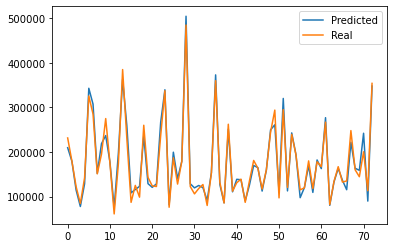

In [26]:
y_predicted = gboost.predict(X_test2)
plot_model(y_test, y_predicted)

## RandomForestRegressor

In [27]:
rfr = RandomForestRegressor(n_estimators = 50, random_state=40,
                          min_impurity_decrease=0.002, min_weight_fraction_leaf = 0.001, min_samples_split = 5)
rfr.fit(X_train,y_train)

RandomForestRegressor(min_impurity_decrease=0.002, min_samples_split=5,
                      min_weight_fraction_leaf=0.001, n_estimators=50,
                      random_state=40)

In [28]:
print_metrics(rfr, rfr.score(X_test2, y_test), y_test, rfr.predict(X_test2))

Коэффициент детерминации: 0.9553034352189255
MSE: 309869448.5159122
RMSE: 17603.109058229235
MAE: 13202.766772967521


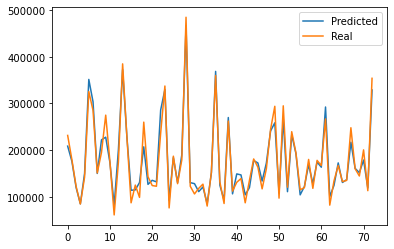

In [29]:
y_predicted = rfr.predict(X_test2)
plot_model(y_test, y_predicted)

## XGBoost

In [30]:
xgboost = XGBRegressor(colsample_bytree = 0.4603, gamma = 0.0468, 
                             learning_rate = 0.05, max_depth = 5, 
                             min_child_weight = 1.4, n_estimators = 1000,
                             reg_alpha = 0.4640, reg_lambda = 0.8571,
                             subsample = 0.5213, random_state = 7, nthread = -1)
xgboost.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=1.4, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, nthread=-1, num_parallel_tree=1,
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, subsample=0.5213, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [31]:
print_metrics(xgboost, xgboost.score(X_test2, y_test), y_test, xgboost.predict(X_test2))

Коэффициент детерминации: 0.9690470140966069
MSE: 214588855.29087517
RMSE: 14648.85167140671
MAE: 10622.481164383562


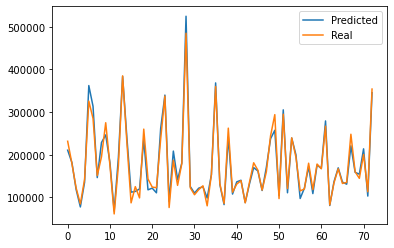

In [32]:
y_predicted = xgboost.predict(X_test2)
plot_model(y_test, y_predicted)

In [33]:
y_result = xgboost.predict(X_test)
sample_submission['SalePrice'] = y_result
sample_submission

,Id,SalePrice
0,1461,123699.125000
1,1462,165747.343750
2,1463,187746.531250
3,1464,194544.765625
4,1465,183579.843750
...,...,...
1454,2915,78605.273438
1455,2916,79222.765625
1456,2917,167942.437500
1457,2918,119779.796875


In [34]:
sample_submission.to_csv("result.csv", index = False)

### Сериализуем модель

In [39]:
model = pickle.dumps(xgboost)
type(model), type(xgboost)
regressor_from_bytes = pickle.loads(model)
with open('model.pkl', 'wb') as output:
       pickle.dump(xgboost, output)

## DecisionTreeRegressor

In [35]:
dtr = DecisionTreeRegressor(random_state = 140, min_samples_split = 5, min_impurity_decrease = 0.002, min_weight_fraction_leaf = 0.001)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(min_impurity_decrease=0.002, min_samples_split=5,
                      min_weight_fraction_leaf=0.001, random_state=140)

In [36]:
print_metrics(dtr, dtr.score(X_test2,y_test) ,y_test, dtr.predict(X_test2))

Коэффициент детерминации: 0.8677587408215467
MSE: 916793633.9937215
RMSE: 30278.600264769862
MAE: 20398.90182648402


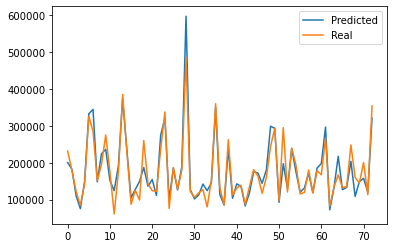

In [37]:
y_predicted = dtr.predict(X_test2)
plot_model(y_test, y_predicted)